In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

### Problem 1. Calculations

$$
\begin{align}
\mathbb{E}||k^{-1/2} \Omega \pmb{x}||^2 &= \frac{1}{k} \mathbb{E} (\pmb{x}^T \Omega^T \Omega \pmb{x})
\\ &= tr \{ \frac{1}{k} \mathbb{E} (\pmb{x}^T \Omega^T \Omega \pmb{x}) \}
\\ &= \frac{1}{k} \mathbb{E} ( tr \{\pmb{x}^T \Omega^T \Omega \pmb{x} \} )
\\ &= \frac{1}{k} \mathbb{E} ({tr \{ (\Omega^T \Omega ) \pmb{x} \pmb{x}^T }\})
\\ &= \frac{1}{k} tr ({\mathbb{E} (\Omega^T \Omega ) \pmb{x} \pmb{x}^T })
\\ & \text { (if Q has mean 0 and variance 1) }
\\ &= tr(\pmb{x} \pmb{x}^T)
\\ &= ||x||^2
\end{align}
$$

### Problem 2. Streamy McStreamface

$$\hat{\pmb{\beta}}_n^\Omega = \Omega^T \mathop{\arg\min}_{\pmb{\beta} \in \mathbb{R}^k} \mathbb{P}_n \{Y - (\Omega \pmb{X})^T \pmb{\beta} \}^2$$

Differentiate $\mathbb{P}_n \{Y - (\Omega \pmb{X})^T \pmb{\beta} \}^2$ according to $\beta$:

\begin{equation}
\begin{split}
\mathbb{P}_n \{[Y - (\Omega \pmb{X})^T \pmb{\beta}]  (\Omega \pmb{X}) \}= 0 \\
\end{split}
\end{equation}

Solve for $\beta$, we have: 

$$\hat{\pmb{\beta}}_n = \mathbb{P}_n \{ (\Omega \pmb{X})(\Omega \pmb{X})^T \}^{-1} \mathbb{P}_n \{(\Omega \pmb{X}) Y\}$$

$$
\begin{align}
\hat{\pmb{\beta}}_n^\Omega &= \Omega^T \hat{\pmb{\beta}}_n
\\ &= \Omega^T \mathbb{P}_n \{ (\Omega \pmb{X})(\Omega \pmb{X})^T \}^{-1} \mathbb{P}_n \{(\Omega \pmb{X}) Y\}
\\ &= \Omega^T \mathbb{P}_n \{ (\Omega \pmb{X})(\Omega \pmb{X})^T \}^{-1} \Omega \mathbb{P}_n \{\pmb{X} Y\}
\\ &= \Omega^T [\Omega \mathbb{P}_n \{\pmb{X}\pmb{X}^T \} \Omega^T]^{-1} \Omega \mathbb{P}_n \{\pmb{X} Y\}
\end{align}
$$

So, we could design an algorithm:

1. Initialize $p \times p$ matrix $M$ and a $p \times 1$ matrix $N$ s.t. $M = \sum_i \pmb{X}_i\pmb{X}_i^T \in \mathbb{R}^{p \times p}$ and $N = \sum_i \pmb{X}_iY_i \in \mathbb{R}^{p \times 1}$. This will only be calculated once since it could store the data with one single pass through with storage requirement $\mathcal{O}(p^2)$. Then $\mathbb{P}_n \{\pmb{X}\pmb{X}^T \} = \frac{M}{n}$  and $\mathbb{P}_n \{\pmb{X} Y\} = \frac{N}{n}$

2. Generate $\{\Omega^{(1)}, \cdots, \Omega^{(B)}\}$ from $Q$.

3. For $b \in \{1, \cdots, B\}$, calculate $\hat{\pmb{\beta}}_n^{\Omega^{(b)}}$ as below:

\begin{equation}
\begin{split}
\hat{\pmb{\beta}}_n^{\Omega^{(b)}} &= {\Omega^{(b)}}^T [\Omega^{(b)} \mathbb{P}_n \{\pmb{X}\pmb{X}^T \} {\Omega^{(b)}}^T]^{-1} \Omega^{(b)} \mathbb{P}_n \{\pmb{X} Y\} \\
&= {\Omega^{(b)}}^T \left[ \Omega^{(b)} \frac{M}{n} {\Omega^{(b)}}^T \right]^{-1} \Omega^{(b)} \frac{N}{n} \\
&= {\Omega^{(b)}}^T \left[ \Omega^{(b)} M {\Omega^{(b)}}^T \right]^{-1} \Omega^{(b)} N
\end{split}
\end{equation}

4. Compute the averaged projected least squares estimator:

$$\hat{\pmb{\beta}}_n^{ave} = \frac{1}{B} \sum_{b=1}^{B} \hat{\pmb{\beta}}_n^{\Omega^{(b)}}$$

### Problem 3. Randy

$\hat{\pmb{\beta}}_n^{\Omega^{(b)}} = {\Omega^{(b)}}^T \left[ \Omega^{(b)} M {\Omega^{(b)}}^T \right]^{-1} \Omega^{(b)} N$ from Problem 2 where $M = \sum_i \pmb{X}_i\pmb{X}_i^T \in \mathbb{R}^{p \times p}$ and $N = \sum_i \pmb{X}_iY_i \in \mathbb{R}^{p \times 1}$. 

We first initialize $M$, $N$ and generate $\{\Omega^{(b)}\}_{b=1}^B$ with old data, then as new data comes in, we update $M$ and $N$ accordingly and take the average of $B$ estimators.

In [75]:
random.seed(42)
# Generate true data
n = 1000
p = 30
k = 5
X_full = np.random.uniform(low = 1, high = 5, size = n * p).reshape(n, p)
# Omega values are either -1 or 1
Omega = 2 * np.random.binomial(n = 1, p = 0.5, size = k * p).reshape(k, p) - 1
beta_true = np.random.uniform(low = 1, high = 4, size = k).reshape(k, 1)
y_full = X_full @ Omega.T @ beta_true + np.random.normal(size = n).reshape(n, 1)

# Create initial data (first n0 observations of X_full); new data from (n0 + 1) to n will come in streamingly
n0 = 10
X = X_full[:n0, :]
y = y_full[:n0, :]
new_X_data = X_full[n0:, :]
new_y_data = y_full[n0:, :]

In [76]:
def streaming(X, y, new_X, new_y, Omegas):
    # Update beta_hat_avg with new data point
    update_X = np.append(X, [new_X], axis=0)
    update_y = np.append(y, [new_y], axis=0)
    #A = A + new_x @ new_x.T
    #B = B + new_y * new_x
    M = update_X.T @ update_X
    N = update_X.T @ update_y
    
    # Update beta average using new data
    new_beta_ave = (
        np.mean(
            np.array(
                [Omega.T @ np.linalg.solve(Omega @ M @ Omega.T, Omega @ N) for Omega in Omegas]
            )
            .reshape(len(Omegas), p), 
            axis = 0))
    
    return update_X, update_y, new_beta_ave

In [77]:
# generate the dimension k for B projection matrices
B = 100
ks = [random.randint(5, 10) for i in range(B)] # draw k from {5, 6, 7, 8, 9, 10}

Omegas = [2 * np.random.binomial(n = 1, p = 0.5, size = k * p).reshape(k, p) - 1 for k in ks]
M = X.T @ X
N = X.T @ y

# Intialize beta_avg using old data
beta_ave = (np.mean(
    np.array(
        [Omega.T @ np.linalg.solve(Omega @ M @ Omega.T, Omega @ N) 
         for Omega in Omegas]).reshape(B, p), 
    axis = 0))

update_X = X.copy()
update_y = y.copy()
new_beta_aves = []
# Store intial beta_ave
new_beta_aves.append(beta_ave)
for i in range(new_X_data.shape[0]):
    update_X, update_y, new_beta_ave = streaming(update_X, update_y, new_X_data[i,:], new_y_data[i], Omegas)
    new_beta_aves.append(new_beta_ave)

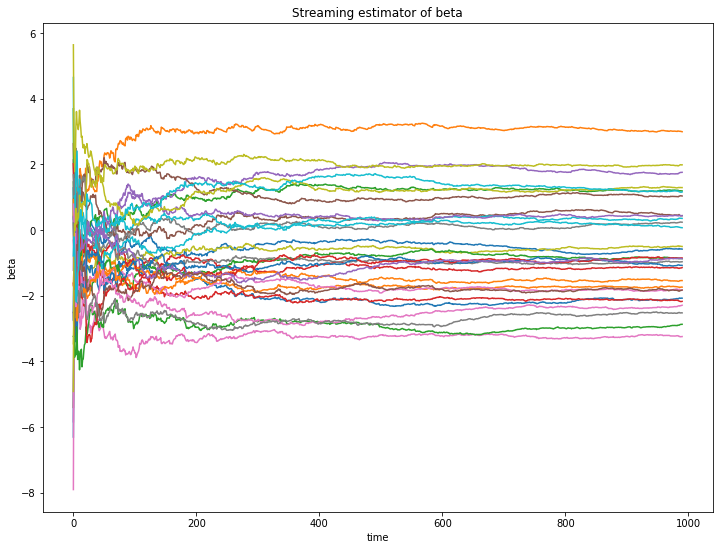

In [84]:
new_beta_aves = np.array(new_beta_aves)
fig, ax = plt.subplots(figsize = (12, 9))
plt.title('Streaming estimator of beta')
for i in range(p):
    plt.plot(new_beta_aves[:, i])
plt.xlabel('time')
plt.ylabel('beta');